In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir src
  !cp -r drive/MyDrive/IFT780/HappyWhale/src/* src/
  !mkdir data
  !cp -r drive/MyDrive/IFT780/HappyWhale/data/* data/
  IN_COLAB = True
  #!pip install timm
except:
  IN_COLAB = False
  #%pip install -r requirements.txt

# Pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# HappyWhale Challenge - Team WhalePlayed

This notebook presents the work done by Gaétan Rey, Julien Levarlet and Timothée Wright, as part of the challenge https://www.kaggle.com/competitions/happy-whale-and-dolphin/overview .

Imports :

In [2]:
import torch.nn as nn
import torch
from src.ModelTrainTestManager import ModelTrainTestManager, optimizer_setup
from src.DataManager import DataManager
from src.Models.ResNet import ResNet
from src.Models.HappyWhaleModel import HappyWhaleModel

torch.cuda.empty_cache()

Parameters for the data :

In [3]:
data_csv = "data/common_train.csv"
dataFolderPath = "data/common_cropped_train_imgs"

Parameters for the training :

In [4]:
batch_size = 5
learning_rate = 0.01
optimizer_factory = optimizer_setup(torch.optim.Adam, lr=learning_rate)

test_percentage = 0.2
val_percentage = 0.2

exp_name = "HappyWhale"


data_manager = DataManager(data_csv, dataFolderPath, batch_size,
                test_percentage, val_percentage, verbose=True)

                image             species  individual_id                  box
0  00021adfb725ed.jpg  melon_headed_whale          12348        2 116 802 665
1  000562241d384d.jpg      humpback_whale           1636    588 597 3504 1477
2  0007c33415ce37.jpg  false_killer_whale           5842      0 453 3183 1589
3  0007d9bca26a99.jpg  bottlenose_dolphin           4551       1 91 2636 1495
4  00087baf5cef7a.jpg      humpback_whale           8721  1139 1590 3574 1913
Dataset size : 51033
Size of validation set : 8166
Size of test set : 10207
Size of train set : 32660


Parameters for the model :

In [5]:
in_channels=3
depth=3
option="small"
size=256
num_class = data_manager.get_number_of_classes()

# ArcFace Hyperparameters
arcFace_config = {
    "s": 30.0,  # scale (The scale parameter changes the shape of the logits. The higher the scale, the more peaky the logits vector becomes.)
    "m": 0.50,  # margin (margin results in a bigger separation of classes in your training set)
    "ls_eps": 0.0,
    "easy_margin": False
}

model = HappyWhaleModel("tf_efficientnet_b0_ns", 512, num_class=num_class, arcface_config=arcFace_config)
#model = ResNet(num_class, in_channels, depth, option, size)

In [6]:
model_trainer = ModelTrainTestManager(model=model,
                                        data_manager = data_manager,
                                        loss_fn=nn.CrossEntropyLoss(),
                                        optimizer_factory=optimizer_factory,
                                        exp_name = exp_name ,
                                        learning_rate=learning_rate,
                                        use_cuda=True)

In [7]:
epoch=1
model_trainer.train(epoch)

  0%|          | 0/6532 [00:00<?, ?it/s]

Epoch: 1 of 1


  3%|▎         | 190/6532 [00:37<20:36,  5.13it/s, loss=0.782] 


KeyboardInterrupt: 

Accuracy on the test set: 1.000 %


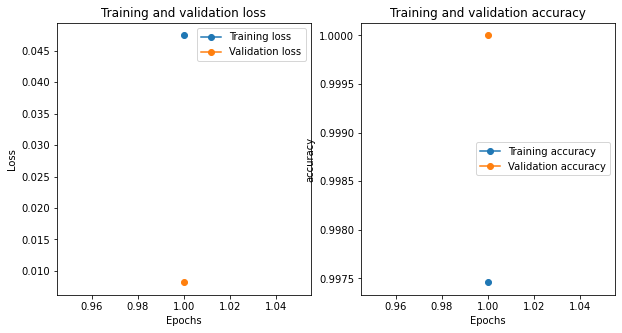

In [ ]:
model_trainer.evaluate_on_test_set()
model_trainer.plot_metrics(exp_name)

In [ ]:
from src.HyperparameterSearch import HyperparameterSearchManager

params = {
    "learning_rate": [0.1,0.01,0.001],
    "arcface_s": [20,30.0,40],
    "arcface_m": [0.4,0.5,0.6],
}

hs = HyperparameterSearchManager(HappyWhaleModel,
                params=params,
                data_manager = data_manager,
                loss_fn=nn.CrossEntropyLoss(),
                optimizer_factory=optimizer_factory,
                exp_name="hyperparameter_search",
                num_epoch=3,)

print(hs.get_best_param())

Parameters : lr 0.1 , s 20 , m 0.4


  0%|          | 0/6532 [00:09<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

Accuracy on the test set: 0.000 %


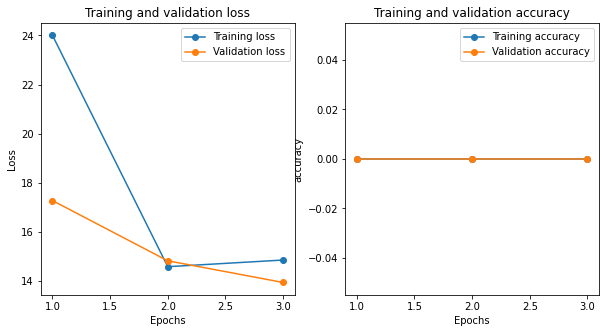

In [ ]:
model = hs.get_best_model()
hs.evaluate_best_on_test_set()
model.save(exp_name)